#***BNB***

#8:2

MAE: 412.7736451487832
RMSE: 429.43265686302914
MAPE: 1.560996678535008
Predictions for the next 30 days: [762.62600277 762.72218519 762.86645882 763.01073246 763.15500609
 763.29927972 763.44355335 763.58782698 763.73210061 763.87637424
 764.02064787 764.1649215  764.30919513 764.45346876 764.59774239
 764.74201602 764.88628965 765.03056328 765.17483691 765.31911054
 765.46338417 765.6076578  765.75193143 765.89620506 766.04047869
 766.18475232 766.32902595 766.47329958 766.61757321 766.71375563]
Predictions for the next 60 days: [762.62600277 762.72218519 762.86645882 763.01073246 763.15500609
 763.29927972 763.44355335 763.58782698 763.73210061 763.87637424
 764.02064787 764.1649215  764.30919513 764.45346876 764.59774239
 764.74201602 764.88628965 765.03056328 765.17483691 765.31911054
 765.46338417 765.6076578  765.75193143 765.89620506 766.04047869
 766.18475232 766.32902595 766.47329958 766.61757321 766.76184684
 766.90612047 767.0503941  767.19466773 767.33894136 767.48321499
 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

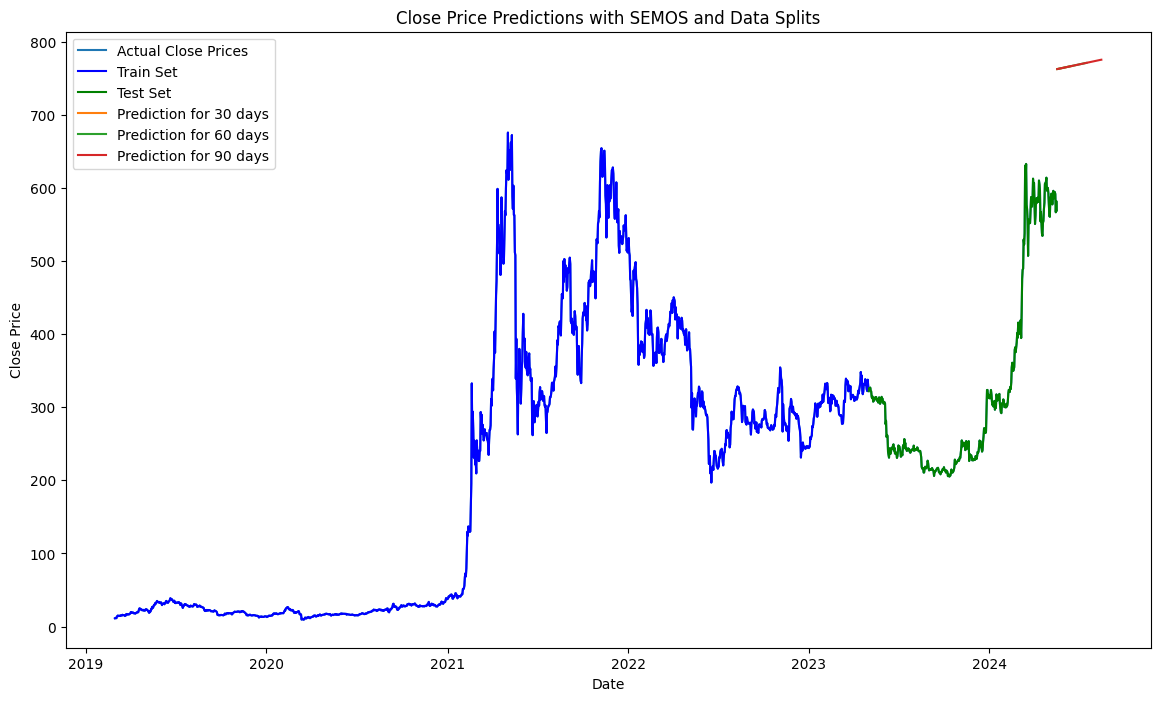

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#7:3

MAE: 315.0923984637224
RMSE: 330.4384323983088
MAPE: 1.171477687999397
Predictions for the next 30 days: [662.71842309 662.7954468  662.91098237 663.02651795 663.14205352
 663.25758909 663.37312466 663.48866023 663.6041958  663.71973137
 663.83526694 663.95080251 664.06633808 664.18187366 664.29740923
 664.4129448  664.52848037 664.64401594 664.75955151 664.87508708
 664.99062265 665.10615822 665.22169379 665.33722937 665.45276494
 665.56830051 665.68383608 665.79937165 665.91490722 665.99193093]
Predictions for the next 60 days: [662.71842309 662.7954468  662.91098237 663.02651795 663.14205352
 663.25758909 663.37312466 663.48866023 663.6041958  663.71973137
 663.83526694 663.95080251 664.06633808 664.18187366 664.29740923
 664.4129448  664.52848037 664.64401594 664.75955151 664.87508708
 664.99062265 665.10615822 665.22169379 665.33722937 665.45276494
 665.56830051 665.68383608 665.79937165 665.91490722 666.03044279
 666.14597836 666.26151393 666.3770495  666.49258508 666.60812065
 6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

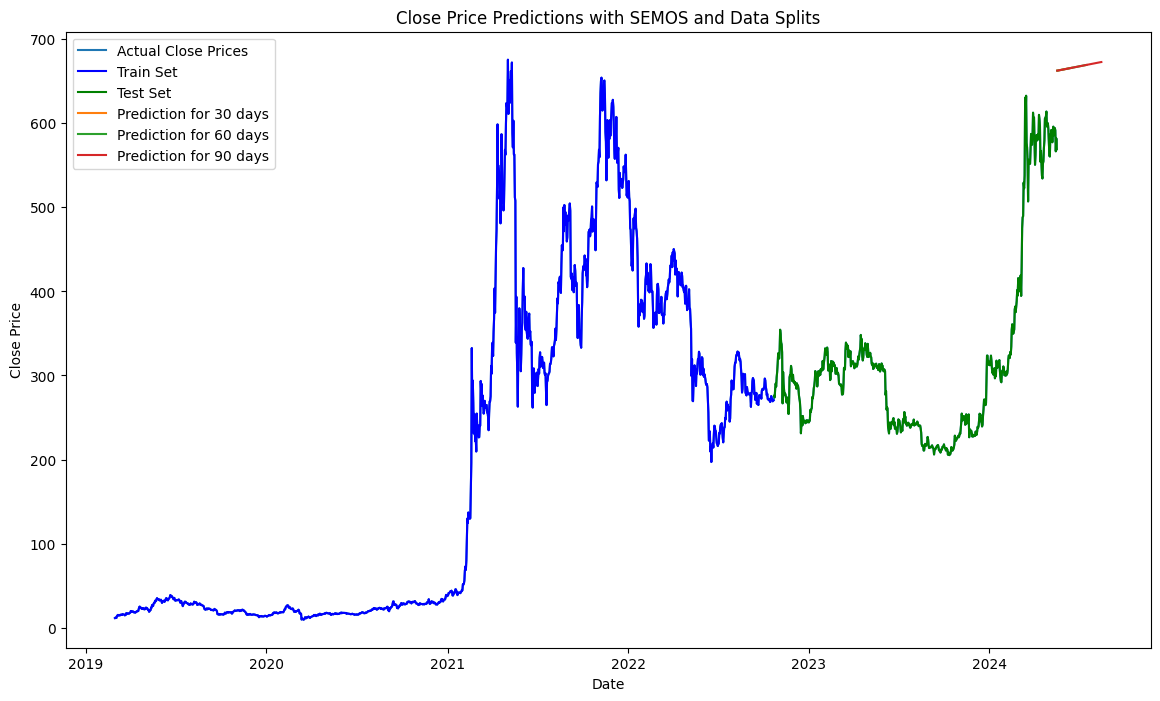

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#6:4

MAE: 631.828902935597
RMSE: 638.3289085852351
MAPE: 2.2609189465604573
Predictions for the next 30 days: [1026.28400575 1026.43416762 1026.65941043 1026.88465324 1027.10989604
 1027.33513885 1027.56038166 1027.78562447 1028.01086728 1028.23611009
 1028.4613529  1028.68659571 1028.91183852 1029.13708132 1029.36232413
 1029.58756694 1029.81280975 1030.03805256 1030.26329537 1030.48853818
 1030.71378099 1030.9390238  1031.1642666  1031.38950941 1031.61475222
 1031.83999503 1032.06523784 1032.29048065 1032.51572346 1032.66588533]
Predictions for the next 60 days: [1026.28400575 1026.43416762 1026.65941043 1026.88465324 1027.10989604
 1027.33513885 1027.56038166 1027.78562447 1028.01086728 1028.23611009
 1028.4613529  1028.68659571 1028.91183852 1029.13708132 1029.36232413
 1029.58756694 1029.81280975 1030.03805256 1030.26329537 1030.48853818
 1030.71378099 1030.9390238  1031.1642666  1031.38950941 1031.61475222
 1031.83999503 1032.06523784 1032.29048065 1032.51572346 1032.74096627
 1032.96

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

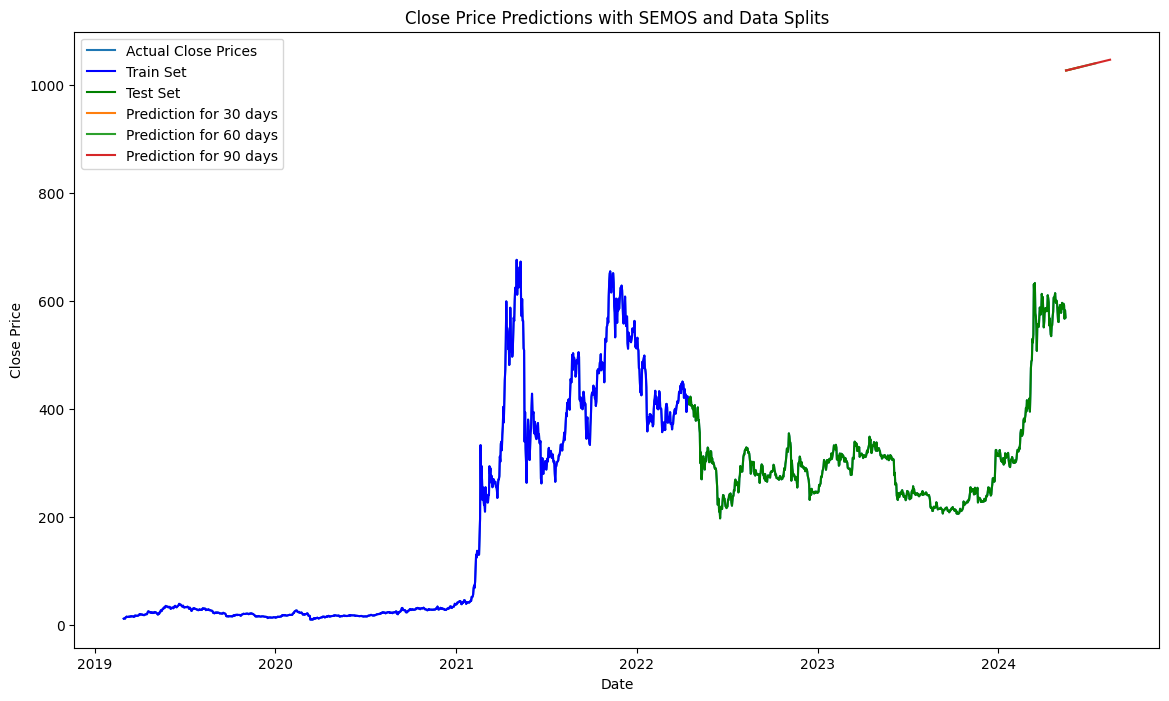

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 6:4 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#***BTC***

#8:2

MAE: 25794.54448434864
RMSE: 28893.87233047001
MAPE: 0.8215478736310102
Predictions for the next 30 days: [68266.93492598 68274.88604673 68286.81272785 68298.73940897
 68310.6660901  68322.59277122 68334.51945234 68346.44613347
 68358.37281459 68370.29949571 68382.22617684 68394.15285796
 68406.07953909 68418.00622021 68429.93290133 68441.85958246
 68453.78626358 68465.7129447  68477.63962583 68489.56630695
 68501.49298807 68513.4196692  68525.34635032 68537.27303145
 68549.19971257 68561.12639369 68573.05307482 68584.97975594
 68596.90643706 68604.85755781]
Predictions for the next 60 days: [68266.93492598 68274.88604673 68286.81272785 68298.73940897
 68310.6660901  68322.59277122 68334.51945234 68346.44613347
 68358.37281459 68370.29949571 68382.22617684 68394.15285796
 68406.07953909 68418.00622021 68429.93290133 68441.85958246
 68453.78626358 68465.7129447  68477.63962583 68489.56630695
 68501.49298807 68513.4196692  68525.34635032 68537.27303145
 68549.19971257 68561.12639369 6857

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

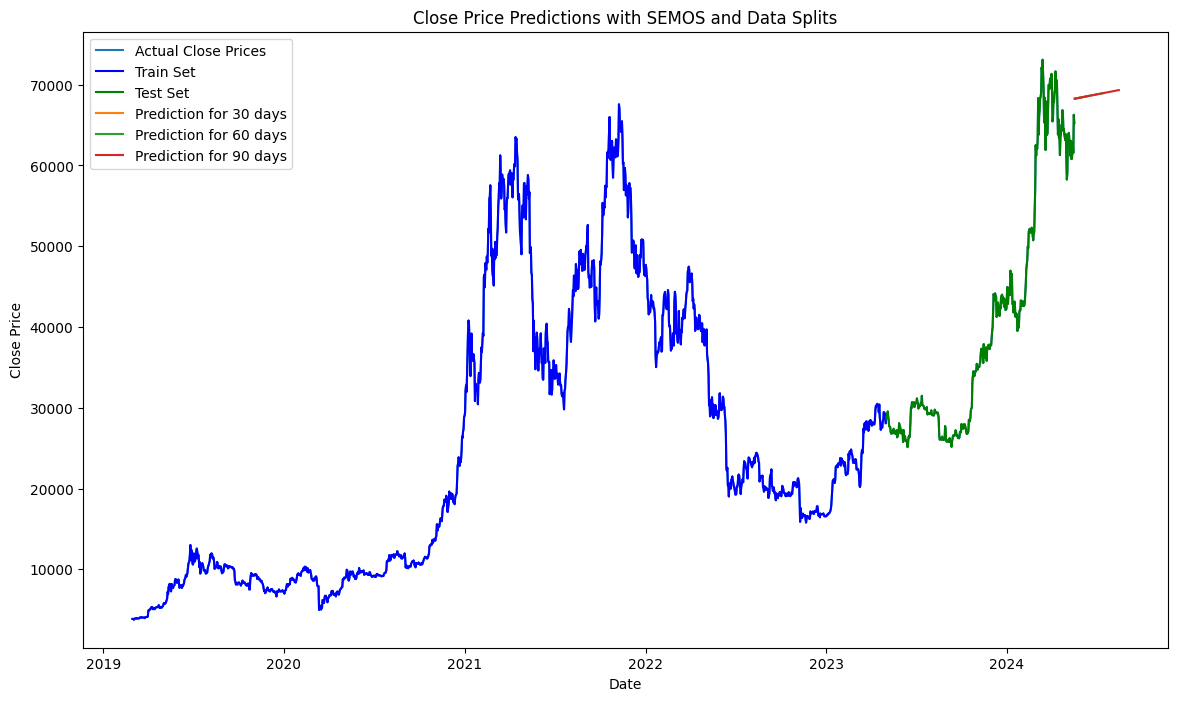

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BTC.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#7:3

MAE: 22822.199101057773
RMSE: 24621.48343043793
MAPE: 0.8939843072499436
Predictions for the next 30 days: [59387.78725235 59397.54033322 59412.16995453 59426.79957583
 59441.42919713 59456.05881844 59470.68843974 59485.31806105
 59499.94768235 59514.57730366 59529.20692496 59543.83654626
 59558.46616757 59573.09578887 59587.72541018 59602.35503148
 59616.98465279 59631.61427409 59646.2438954  59660.8735167
 59675.503138   59690.13275931 59704.76238061 59719.39200192
 59734.02162322 59748.65124453 59763.28086583 59777.91048713
 59792.54010844 59802.29318931]
Predictions for the next 60 days: [59387.78725235 59397.54033322 59412.16995453 59426.79957583
 59441.42919713 59456.05881844 59470.68843974 59485.31806105
 59499.94768235 59514.57730366 59529.20692496 59543.83654626
 59558.46616757 59573.09578887 59587.72541018 59602.35503148
 59616.98465279 59631.61427409 59646.2438954  59660.8735167
 59675.503138   59690.13275931 59704.76238061 59719.39200192
 59734.02162322 59748.65124453 59763

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

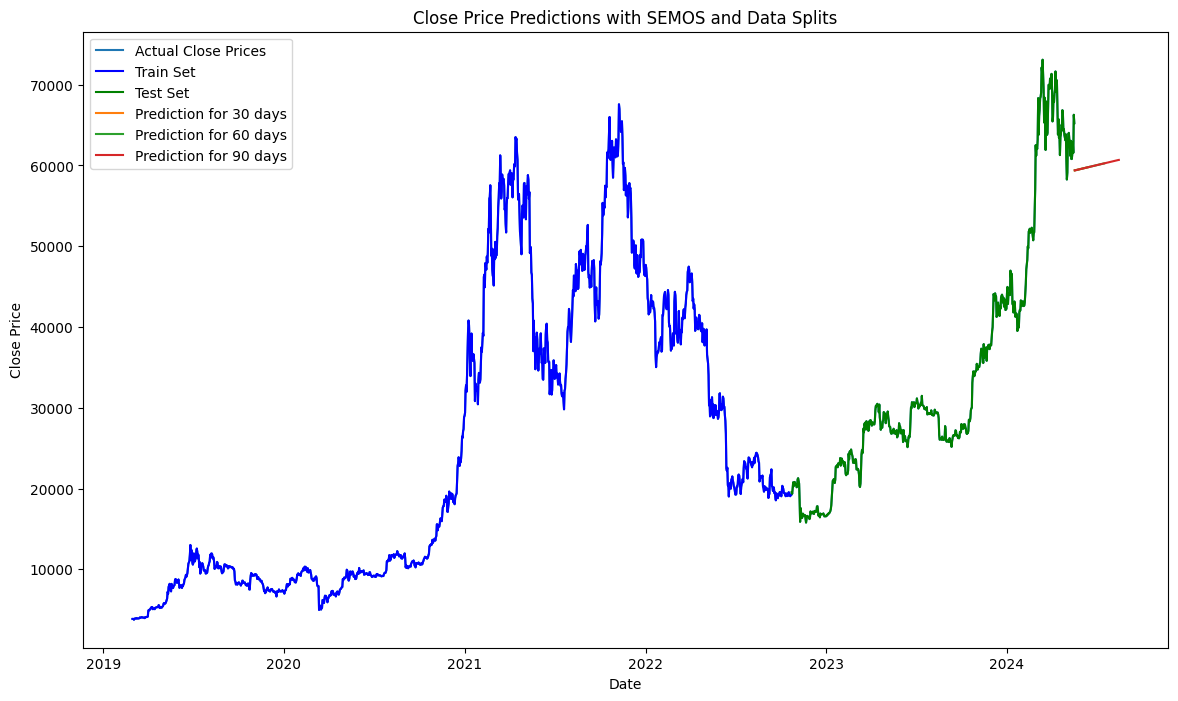

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BTC.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#6:4

MAE: 62900.18442193683
RMSE: 63878.88637622303
MAPE: 2.41131513334016
Predictions for the next 30 days: [102966.97412742 102981.22347351 103002.59749266 103023.9715118
 103045.34553094 103066.71955008 103088.09356923 103109.46758837
 103130.84160751 103152.21562665 103173.5896458  103194.96366494
 103216.33768408 103237.71170322 103259.08572237 103280.45974151
 103301.83376065 103323.20777979 103344.58179894 103365.95581808
 103387.32983722 103408.70385636 103430.07787551 103451.45189465
 103472.82591379 103494.19993293 103515.57395208 103536.94797122
 103558.32199036 103572.57133646]
Predictions for the next 60 days: [102966.97412742 102981.22347351 103002.59749266 103023.9715118
 103045.34553094 103066.71955008 103088.09356923 103109.46758837
 103130.84160751 103152.21562665 103173.5896458  103194.96366494
 103216.33768408 103237.71170322 103259.08572237 103280.45974151
 103301.83376065 103323.20777979 103344.58179894 103365.95581808
 103387.32983722 103408.70385636 103430.07787551 1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

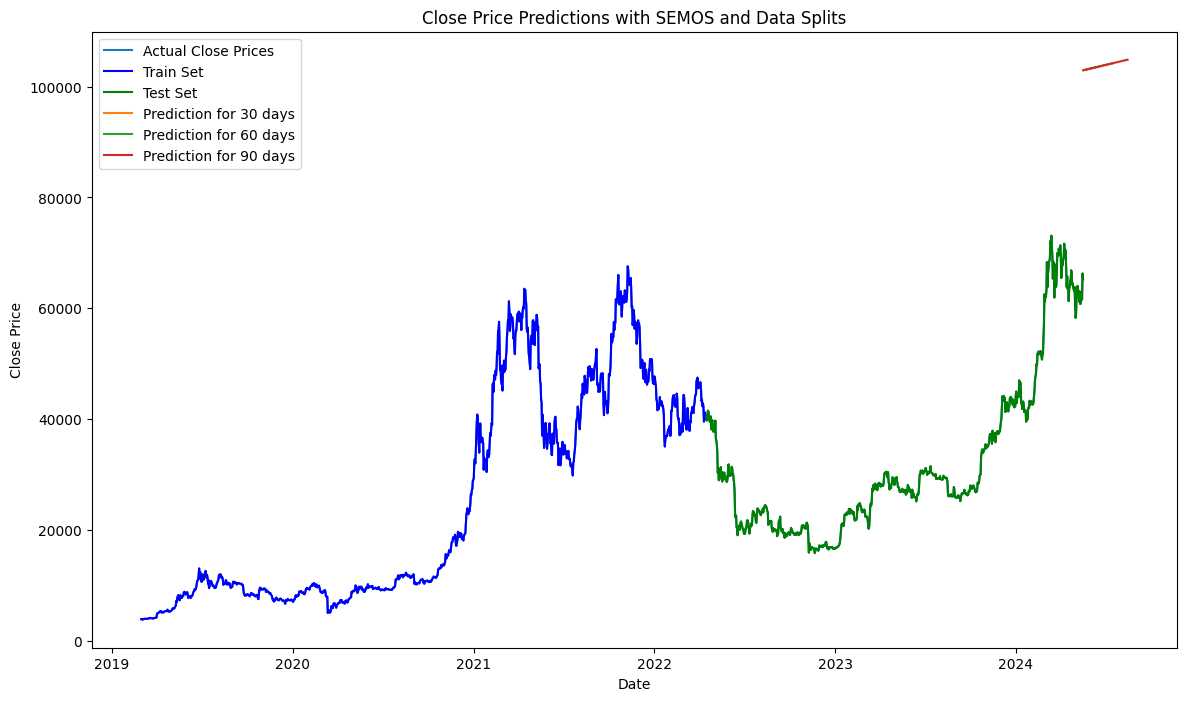

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/BTC.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 6:4 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#***ETH***

#8:2

MAE: 2001.5983520417421
RMSE: 2083.170589181101
MAPE: 1.0080294823274096
Predictions for the next 30 days: [4421.27506318 4421.80371318 4422.59668818 4423.38966318 4424.18263819
 4424.97561319 4425.76858819 4426.5615632  4427.3545382  4428.1475132
 4428.94048821 4429.73346321 4430.52643821 4431.31941321 4432.11238822
 4432.90536322 4433.69833822 4434.49131323 4435.28428823 4436.07726323
 4436.87023824 4437.66321324 4438.45618824 4439.24916325 4440.04213825
 4440.83511325 4441.62808826 4442.42106326 4443.21403826 4443.74268826]
Predictions for the next 60 days: [4421.27506318 4421.80371318 4422.59668818 4423.38966318 4424.18263819
 4424.97561319 4425.76858819 4426.5615632  4427.3545382  4428.1475132
 4428.94048821 4429.73346321 4430.52643821 4431.31941321 4432.11238822
 4432.90536322 4433.69833822 4434.49131323 4435.28428823 4436.07726323
 4436.87023824 4437.66321324 4438.45618824 4439.24916325 4440.04213825
 4440.83511325 4441.62808826 4442.42106326 4443.21403826 4444.00701327
 4444.79

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

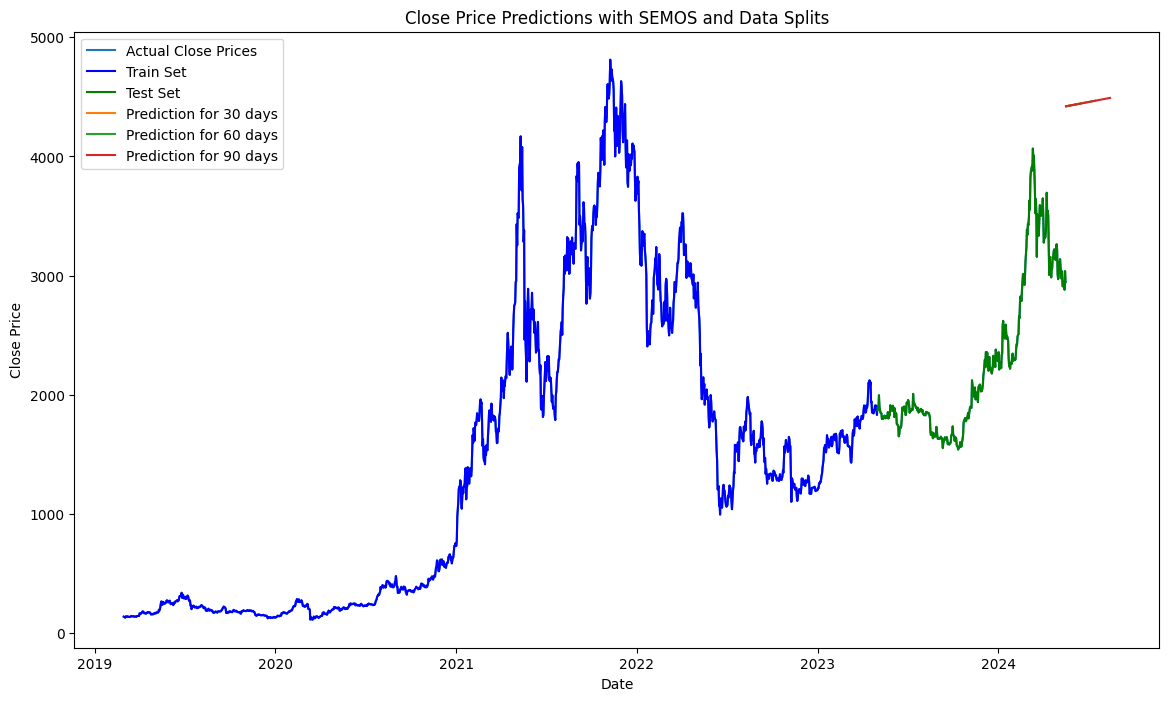

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/ETH.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#7:3

MAE: 1558.9102352934995
RMSE: 1639.7164541813192
MAPE: 0.9064308091015613
Predictions for the next 30 days: [3857.31322081 3857.96287425 3858.9373544  3859.91183455 3860.88631471
 3861.86079486 3862.83527502 3863.80975517 3864.78423533 3865.75871548
 3866.73319564 3867.70767579 3868.68215594 3869.6566361  3870.63111625
 3871.60559641 3872.58007656 3873.55455672 3874.52903687 3875.50351703
 3876.47799718 3877.45247733 3878.42695749 3879.40143764 3880.3759178
 3881.35039795 3882.32487811 3883.29935826 3884.27383842 3884.92349185]
Predictions for the next 60 days: [3857.31322081 3857.96287425 3858.9373544  3859.91183455 3860.88631471
 3861.86079486 3862.83527502 3863.80975517 3864.78423533 3865.75871548
 3866.73319564 3867.70767579 3868.68215594 3869.6566361  3870.63111625
 3871.60559641 3872.58007656 3873.55455672 3874.52903687 3875.50351703
 3876.47799718 3877.45247733 3878.42695749 3879.40143764 3880.3759178
 3881.35039795 3882.32487811 3883.29935826 3884.27383842 3885.24831857
 3886.2

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

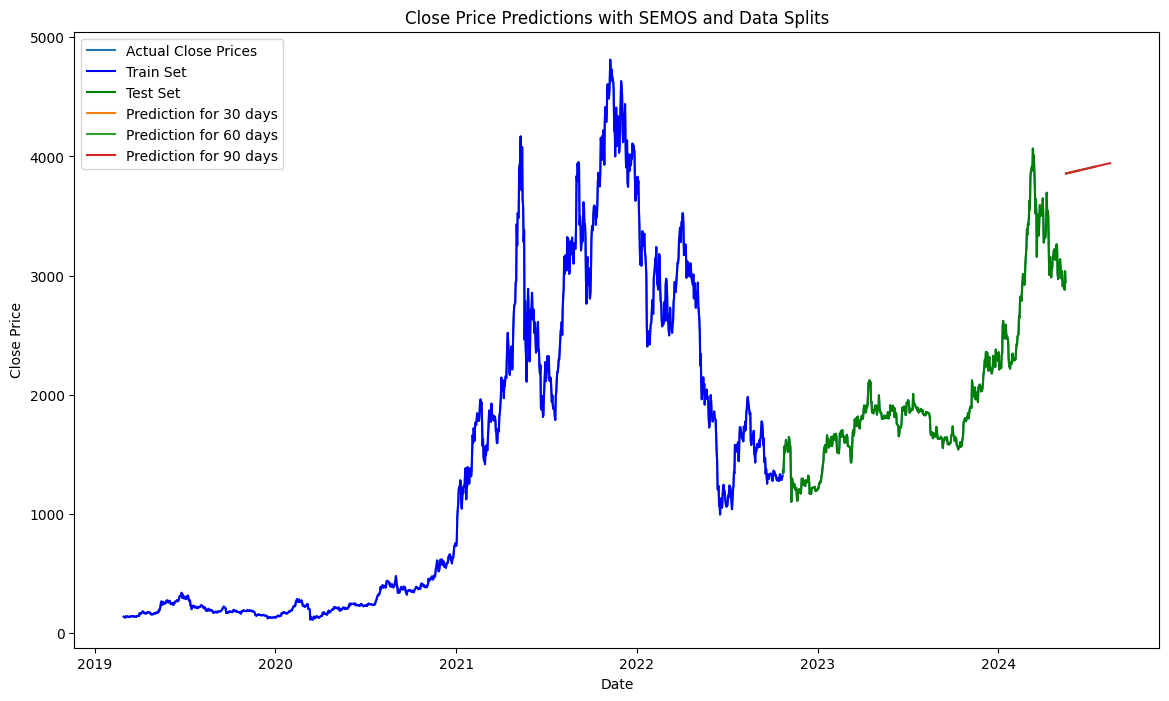

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/ETH.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()


#6:4

MAE: 4996.8929346307705
RMSE: 5022.018226266549
MAPE: 2.8708594921554234
Predictions for the next 30 days: [7604.04782929 7605.21112677 7606.95607299 7608.70101922 7610.44596544
 7612.19091166 7613.93585789 7615.68080411 7617.42575033 7619.17069656
 7620.91564278 7622.660589   7624.40553523 7626.15048145 7627.89542767
 7629.6403739  7631.38532012 7633.13026634 7634.87521257 7636.62015879
 7638.36510501 7640.11005124 7641.85499746 7643.59994369 7645.34488991
 7647.08983613 7648.83478236 7650.57972858 7652.3246748  7653.48797228]
Predictions for the next 60 days: [7604.04782929 7605.21112677 7606.95607299 7608.70101922 7610.44596544
 7612.19091166 7613.93585789 7615.68080411 7617.42575033 7619.17069656
 7620.91564278 7622.660589   7624.40553523 7626.15048145 7627.89542767
 7629.6403739  7631.38532012 7633.13026634 7634.87521257 7636.62015879
 7638.36510501 7640.11005124 7641.85499746 7643.59994369 7645.34488991
 7647.08983613 7648.83478236 7650.57972858 7652.3246748  7654.06962103
 7655.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not h

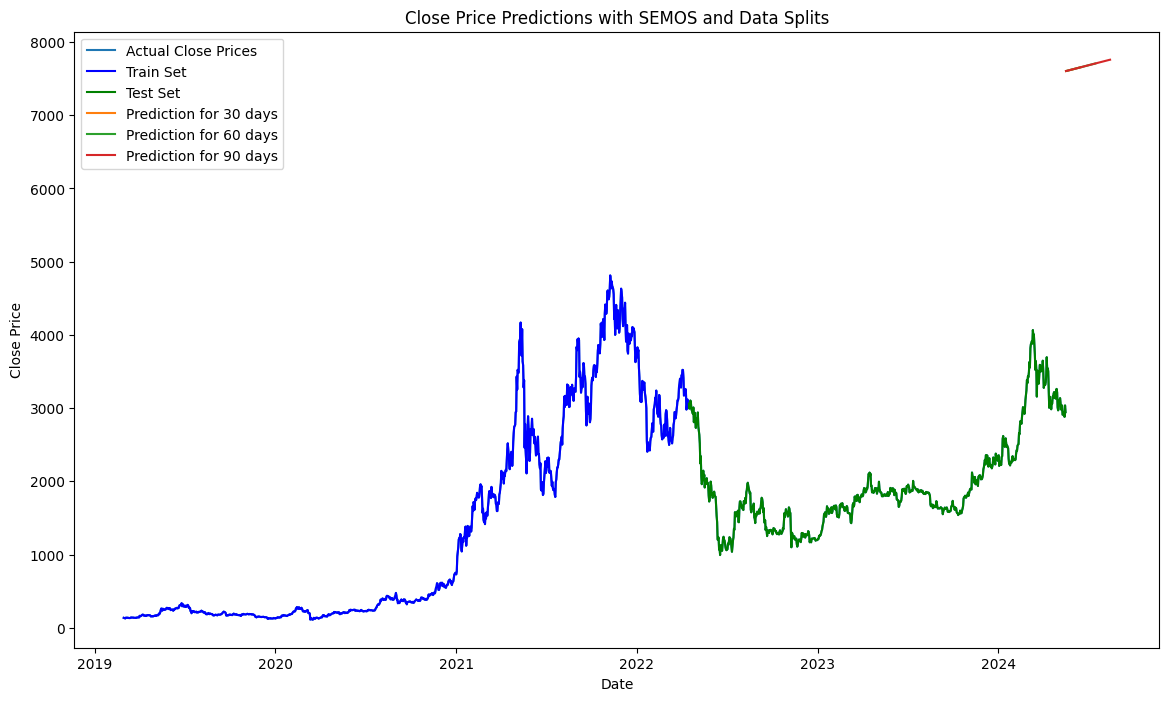

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the CSV file
file_path = '/content/ETH.csv'
data = pd.read_csv(file_path)

# Convert the Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'Day' as the number of days since the start date
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Prepare features and target
X = data[['Day']]
y = data['Close']

# Split data into train and test sets with 6:4 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Make predictions
predictions = {model_name: model.predict(X_test) for model_name, model in models.items()}

# Calculate weights based on test set performance
def calculate_weights(models, X_test, y_test):
    errors = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        errors[model_name] = np.mean(np.abs((y_test - y_pred) / y_test))
    total_error = sum(errors.values())
    weights = {model_name: (1 - error / total_error) for model_name, error in errors.items()}
    return weights

weights = calculate_weights(models, X_test, y_test)

# Calculate weighted average predictions
combined_predictions = np.zeros(len(X_test))
for model_name, prediction in predictions.items():
    combined_predictions += weights[model_name] * prediction

# Apply smoothing to the combined predictions
combined_predictions_smoothed = uniform_filter1d(combined_predictions, size=3)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, combined_predictions_smoothed)
mse = mean_squared_error(y_test, combined_predictions_smoothed)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - combined_predictions_smoothed) / y_test))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Predict the future 'Close' prices for 30, 60, and 90 days
future_days = [30, 60, 90]
future_predictions = {}

last_day = X['Day'].max()
for days in future_days:
    future_X = np.array([last_day + i for i in range(1, days + 1)]).reshape(-1, 1)
    future_combined_predictions = np.zeros(len(future_X))
    for model_name, model in models.items():
        future_combined_predictions += weights[model_name] * model.predict(future_X)
    future_combined_predictions_smoothed = uniform_filter1d(future_combined_predictions, size=3)
    future_predictions[days] = future_combined_predictions_smoothed

# Print daily predictions for 30, 60, and 90 days
for days, prediction in future_predictions.items():
    print(f"Predictions for the next {days} days: {prediction}")

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], y, label='Actual Close Prices')

# Plot train and test sets
plt.plot(data['Date'][:len(X_train)], y_train, label='Train Set', color='blue')
plt.plot(data['Date'][len(X_train):], y_test, label='Test Set', color='green')

# Plot future predictions
for days, prediction in future_predictions.items():
    future_dates = [data['Date'].max() + pd.Timedelta(days=i) for i in range(1, days + 1)]
    plt.plot(future_dates, prediction, label=f'Prediction for {days} days')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Predictions with SEMOS and Data Splits')
plt.legend()
plt.show()
